In [1]:
import sys
# This on is a path correcting code, which is used to find the path of qusim.
sys.path.append('../../../..')
import qusim.DataPlot.plot_lib as pl
import qusim.Instruments.tools as tools
import qusim.Instruments.stochastic_gen as sg
import qusim.System.arb_qubit_system as aqs
import qusim.Instruments.angle as  ang

import numpy as np
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy

from qutip import*

# Some useful tools
# Some intrinsic plotting function


def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

def get_angle(tstate, spt):
    if isket(spt):
        if isket(tstate):
            angle = np.angle(tstate.dag() * spt)[0][0]
    else:
        if isket(tstate):
            length = spt.dims[0][0]
            # print(length)
            # print(tstate.dims)
            # print(Qobj(np.insert(np.angle(spt.full()[0][1:length]), 0 ,0)).dims)
            angle_qobj = Qobj(np.insert(np.angle(spt.full()[0][1:length]), 0 ,0)).dag() * tstate
            angle = angle_qobj.full()[0][0]
        else: angle = None
    if angle <0:
        angle += 2*np.pi
    return angle

def phase_tracking(res, state):
    angle_list = []
    for spt in res.states:
        angle_list.append(get_angle(state, spt))
    return angle_list

## Two bit case

In [188]:
freq_list = [
    [0, 6.3],
    [0, 5.8]
]


inter_list = [
    {
        "v01": 1
    },
    {
        "v01": 1
    }
]

r_dic = {
    "r12": 0.04
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list = [
    {
        "v01": 0
    },
    {
        "v01": 0
    }
]

driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }

]

bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }

]

gamma_list = [
    {
        'up': 0,
        'down': 0,
        'z': 4e-3
    },
    {
        'up': 0,
        'down': 0,
        'z': 5e-3
    }
]


# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)
_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.25132741]
 [ 0.         36.44247478  0.25132741  0.        ]
 [ 0.          0.25132741 39.58406744  0.        ]
 [ 0.25132741  0.          0.         76.02654222]]

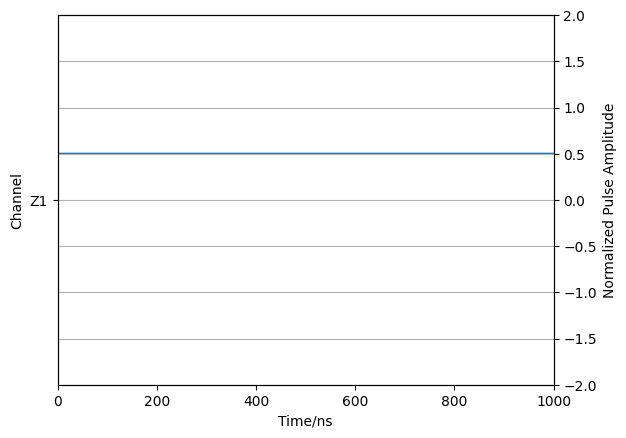

0

In [189]:
state_00, E_00, _ = _system_arb1.get_eigenstates_energy((0,0))
state_01, E_01, _ = _system_arb1.get_eigenstates_energy((0,1))
state_10, E_10, _ = _system_arb1.get_eigenstates_energy((1,0))
state_11, E_11, _ = _system_arb1.get_eigenstates_energy((1,1))

l1 = (state_10 + state_01)/np.sqrt(2)
l0 = (-state_10 + state_01)/np.sqrt(2)

simulation_option1 = {
    "simulation_time": 1000, # ns
    "simulation_step": 20000,
    "initial_state": [ket2dm(l1)] # Do multiple simulation
}

pulse_sequence1 = [
    {
        'pulse_index': 1,
        'type': "Z", # 'XY' or 'Z'
        'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau': 1000 , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'epsilon': 0.1,
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.5,
        'q_index': 1 # 0, 1, 2
    }]
pl.plot_pulse_sequence(copy.deepcopy(pulse_sequence1), simulation_option1)

In [190]:
s0 = basis(2,0)
s1 = basis(2,1)
L00 = tensor(l0, s0)
L10 = tensor(l1, s0)
L01 = tensor(l0, s1)
L11 = tensor(l1, s1)

In [194]:
L01

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.        ]
 [0.        ]
 [0.        ]
 [0.76091737]
 [0.        ]
 [0.64884879]
 [0.        ]
 [0.        ]]

In [74]:
s0 = basis(2,0)
s1 = basis(2,1)
s0l0 = tensor(l0, s0)
s0l1 = tensor(l1, s0)
s1l0 = tensor(l0, s1)
s1l1 = tensor(l1, s1)

ss1 = tensor(state_00, s0)
ss2 = tensor(state_11, s0)
ss3 = tensor(state_00, s1)
ss4 = tensor(state_11, s1)

CZ = s0l0 * s0l0.dag() + s1l0 * s1l0.dag()  + s0l1 * s0l1.dag() - s1l1 * s1l1.dag() + ss1 * ss1.dag() + ss2 * ss2.dag() + ss3 * ss3.dag() + ss4 * ss4.dag()
CZ

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.1579905   0.          0.98744063
   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.98744063  0.         -0.1579905
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]]

In [21]:
result_list1, angle_list1 = _system_arb1.system_dynamics_mesolve(simulation_option1, pulse_sequence1)

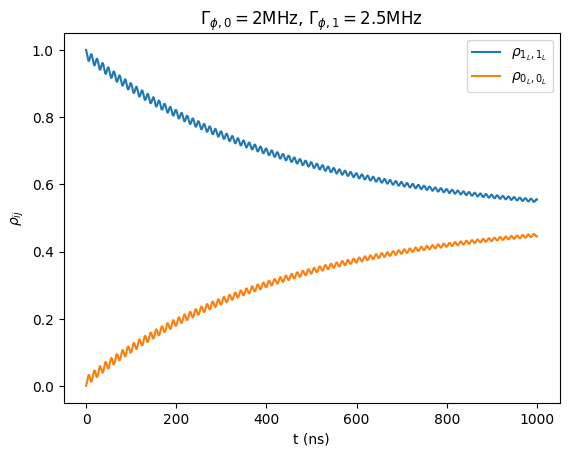

In [28]:
t = np.linspace(0, simulation_option1['simulation_time'], simulation_option1['simulation_step'])

# Select which result you want to see
result = result_list1[0]

# Plot
%matplotlib inline

plt.plot(t,aqs.expect(result.states, l1 * aqs.dag(l1)), label=r'$\rho_{1_L,1_L}$');

plt.plot(t,aqs.expect(result.states, l0 * aqs.dag(l0)), label=r'$\rho_{0_L,0_L}$');

plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.title(r'$\Gamma_{\phi,0} = 2$MHz, $\Gamma_{\phi,1} = 2.5$MHz')
plt.legend()
plt.show()

## Two bit + accela

In [310]:
freq_list = [
    [0, 6.3],
    [0, 5.8],
    [0, 3.175]
]

inter_list = [
    {
        "v01": 1
        # "v00": 1,
        # "v11": -1
    },
    {
        "v01": 1
        # "v00": 1,
        # "v11": -1
    },
    {
        "v01": 1
        # "v00": 1,
        # "v11": -1
    }
]

r_dic = {
    "r12": 0.04,
    "r23": 0.12
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list = [
    {
        "v01": 0
    },
    {
        "v01": 0
    }
    ,
    {
        "v01": 0
    }
]

driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }

]

bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }

]

gamma_list = [
    {
        'up': 0,
        'down': 0,
        'z': 2e-3 * 0
    },
    {
        'up': 0,
        'down': 0,
        'z': 3e-3 * 0
    },
    {
        'up': 0,
        'down': 0,
        'z': 0
    }
]


# gamma_list = None

_system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)
# _system_arb.H

state_000, E_000, _ = _system_arb.get_eigenstates_energy((0,0,0))
state_010, E_010, _ = _system_arb.get_eigenstates_energy((0,1,0))
state_100, E_100, _ = _system_arb.get_eigenstates_energy((1,0,0))
state_110, E_110, _ = _system_arb.get_eigenstates_energy((1,1,0))

state_101, E_101, _ = _system_arb.get_eigenstates_energy((1,0,1))
state_011, E_011, _ = _system_arb.get_eigenstates_energy((0,1,1))

# Define the logic state
L00 = (state_010 - state_100)/np.sqrt(2) # L00 
L10 = (state_010 + state_100)/np.sqrt(2) # L10
L01 = (state_011 - state_101)/np.sqrt(2) # L01
L11 = (state_011 + state_101)/np.sqrt(2) # L11

# L00 = (state_010 + state_100)/np.sqrt(2) # L00 
# L10 = -(state_010 - state_100)/np.sqrt(2) # L10
# L01 = (state_011 - state_101)/np.sqrt(2) # L01
# L11 = (state_011 + state_101)/np.sqrt(2) # L11

E_L00 = expect(_system_arb.H, L00)/(2*np.pi)
E_L10 = expect(_system_arb.H, L10)/(2*np.pi)
E_L01 = expect(_system_arb.H, L01)/(2*np.pi)
E_L11 = expect(_system_arb.H, L11)/(2*np.pi)

### Angle calibration

In [218]:
state_000, E_000, _ = _system_arb.get_eigenstates_energy((0,0,0))
state_010, E_010, _ = _system_arb.get_eigenstates_energy((0,1,0))
state_100, E_100, _ = _system_arb.get_eigenstates_energy((1,0,0))
state_110, E_110, _ = _system_arb.get_eigenstates_energy((1,1,0))

state_101, E_101, _ = _system_arb.get_eigenstates_energy((1,0,1))
state_011, E_011, _ = _system_arb.get_eigenstates_energy((0,1,1))

In [213]:
print(expect(_system_arb.H, (state_010 - state_100)/np.sqrt(2))/(2*np.pi))
E_L00 = expect(_system_arb.H, (state_010 - state_100)/np.sqrt(2))/(2*np.pi)
L00 = (state_010 - state_100)/np.sqrt(2) # L00 # L10

6.05193565837062


In [214]:
print(expect(_system_arb.H, (state_010 + state_100)/np.sqrt(2))/(2*np.pi))
E_L10=expect(_system_arb.H, (state_010 + state_100)/np.sqrt(2)/(2*np.pi))
L10 = (state_010 + state_100)/np.sqrt(2)  #L10# L00

6.051935658370615


In [215]:
print(expect(_system_arb.H, (state_011 - state_101)/np.sqrt(2))/(2*np.pi))
E_L01=expect(_system_arb.H,  (state_011 - state_101)/np.sqrt(2))
L01 = (state_011 - state_101)/np.sqrt(2) # L01

9.223064341629382


In [216]:
print(expect(_system_arb.H, (state_011 + state_101)/np.sqrt(2))/(2*np.pi))
E_L11=expect(_system_arb.H,  (state_011 + state_101)/np.sqrt(2))
L11 = (state_011 + state_101)/np.sqrt(2) # L11

9.223064341629385


In [224]:
print(expect(_system_arb.H, L00)/(2*np.pi))
print(E_010)
L00

6.341371678983928
6.341606286803063


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.03422345]
 [-0.76078492]
 [ 0.        ]
 [-0.64804067]
 [ 0.        ]
 [ 0.        ]
 [ 0.00885115]]

In [226]:
print(expect(_system_arb.H, L10)/(2*np.pi))
print(E_100)
L10

6.261550204939499
6.2614762830428425


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.03011316]
 [-0.64740154]
 [ 0.        ]
 [ 0.76148809]
 [ 0.        ]
 [ 0.        ]
 [-0.01001662]]

In [111]:
E_011 - E_101 -E_010 + E_100

-2.6645352591003757e-15

In [174]:
print(E_011,  E_101, E_010, E_100)

9.513523716957158 9.43339371319694 6.341606286803063 6.2614762830428425


In [175]:
print(E_010)
state_010 # L10

6.341606286803063


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.02766999]
 [ 0.7330868 ]
 [ 0.        ]
 [ 0.67951553]
 [ 0.        ]
 [ 0.        ]
 [-0.00876129]]

In [176]:
print(E_101)
state_101 #L01

9.43339371319694


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[-0.00876129]
 [ 0.        ]
 [ 0.        ]
 [-0.67951553]
 [ 0.        ]
 [ 0.7330868 ]
 [-0.02766999]
 [ 0.        ]]

In [177]:
print(E_100)
state_100 # L10

6.2614762830428425


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.02651963]
 [-0.67905463]
 [ 0.        ]
 [ 0.7335516 ]
 [ 0.        ]
 [ 0.        ]
 [-0.00914124]]

In [178]:
print(E_011)
state_011 # L11

9.513523716957158


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[-0.00914124]
 [ 0.        ]
 [ 0.        ]
 [-0.7335516 ]
 [ 0.        ]
 [-0.67905463]
 [ 0.02651963]
 [ 0.        ]]

### Energy levels

In [315]:
num_level = 8 # Num of level we want to see
w3_scan_space= np.linspace(3.175, 7, 2000)
# flist = copy.deepcopy(freq_list)
zeta_list = []
energy_level_list = []
for w3 in w3_scan_space:
    flist = copy.deepcopy(freq_list)
    
    flist[2][1] = w3
    _system_arb_scan = aqs.arb_qubit_system(flist, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

    state_000, E_000, _ = _system_arb_scan.get_eigenstates_energy((0,0,0))
    state_010, E_010, _ = _system_arb_scan.get_eigenstates_energy((0,1,0))
    state_100, E_100, _ = _system_arb_scan.get_eigenstates_energy((1,0,0))
    state_110, E_110, _ = _system_arb_scan.get_eigenstates_energy((1,1,0))
    state_101, E_101, _ = _system_arb_scan.get_eigenstates_energy((1,0,1))
    state_011, E_011, _ = _system_arb_scan.get_eigenstates_energy((0,1,1))

    # Define the logic state
    L00 = (state_010 - state_100)/np.sqrt(2) # L00 
    L10 = (state_010 + state_100)/np.sqrt(2) # L10
    # L01 = (state_011 - state_101)/np.sqrt(2) # L01
    # L11 = (state_011 + state_101)/np.sqrt(2) # L11

    flist[1][1] = 6.3
    
    _system_arb_scan = aqs.arb_qubit_system(flist, inter_list, r, extra_list, gamma_list, driving_list, bias_list)
    E_L00 = expect(_system_arb_scan.H, L00)/(2*np.pi)
    E_L10 = expect(_system_arb_scan.H, L10)/(2*np.pi)
    # E_L01 = expect(_system_arb_scan.H, L01)/(2*np.pi)
    # E_L11 = expect(_system_arb_scan.H, L11)/(2*np.pi)
    dummy_list = np.sort([E_L00, E_L10])
    # dummy_list = np.sort([E_L00, E_L10, E_L01, E_L11])
    dummy_list = dummy_list - dummy_list[0]
    # zeta_list.append(dummy_list[3] - dummy_list[1] - dummy_list[2])
    energy_level_list.append(dummy_list)

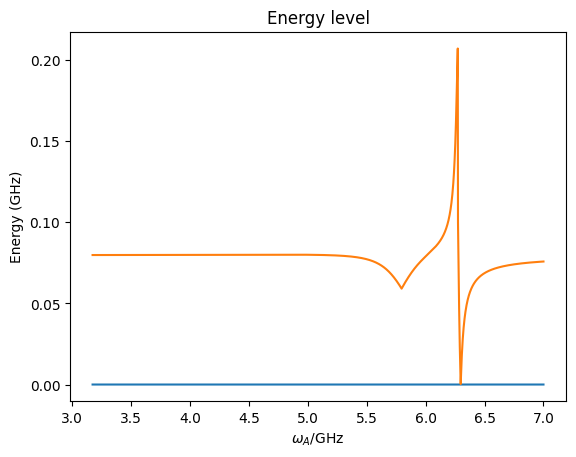

0

In [316]:
%matplotlib inline
pl.plot_Elevel_dynamics(w3_scan_space, energy_level_list, [0,2], "\omega_A")

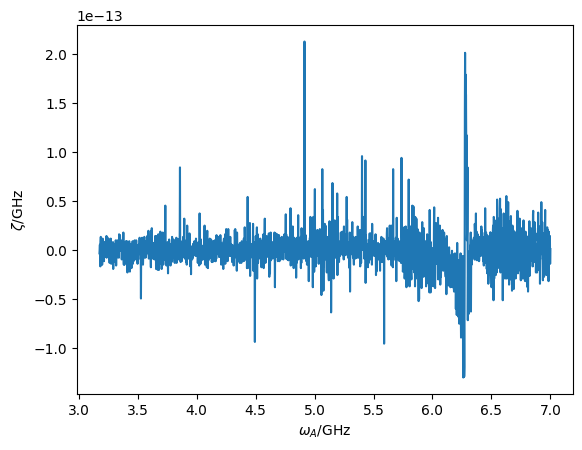

In [313]:
plt.figure()
plt.plot(w3_scan_space, zeta_list)
plt.xlabel(r"$\omega_A$/GHz")
plt.ylabel(r"$\zeta$/GHz")
plt.show()

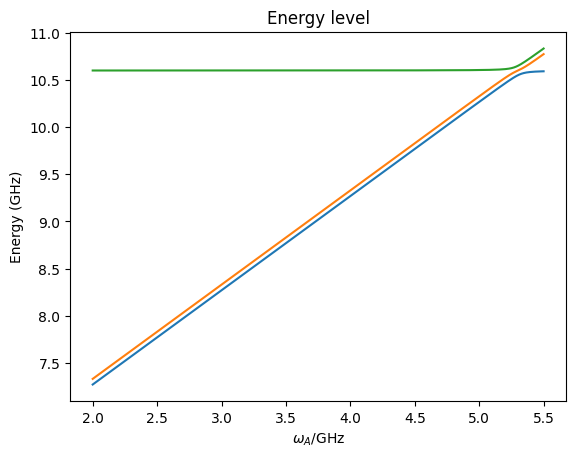

0

In [78]:
%matplotlib inline
pl.plot_Elevel_dynamics(w3_scan_space, energy_level_list, [4,7], "\omega_A")

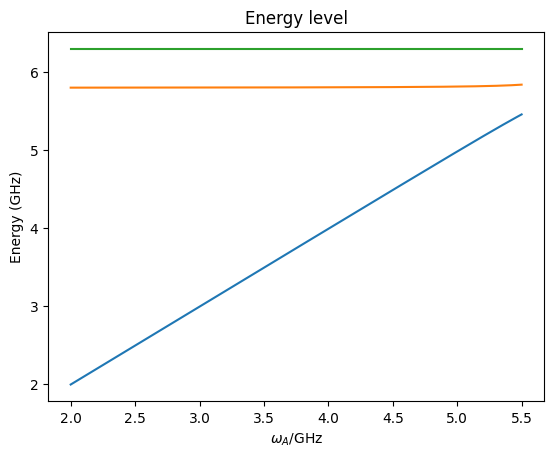

0

In [79]:
%matplotlib inline
pl.plot_Elevel_dynamics(w3_scan_space, energy_level_list, [1,4], "\omega_A")

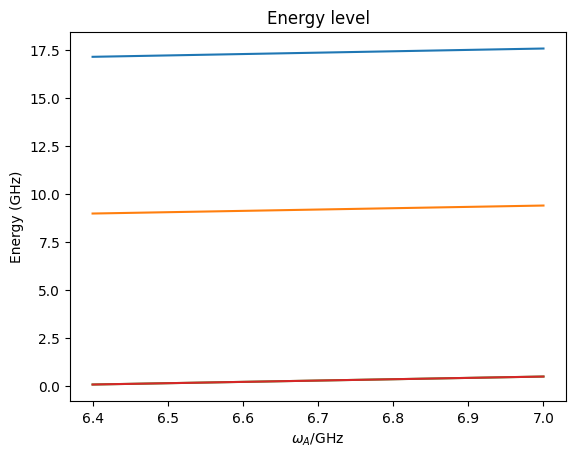

8.183042453793272

In [104]:
earr = np.transpose(np.array(energy_level_list))
elist_new = []
Elist_L11 = (earr[5]+earr[4])/np.sqrt(2)
Elist_L10 = (earr[2]+earr[3])/np.sqrt(2)
Elist_L01 = (earr[5]-earr[4])/np.sqrt(2)
Elist_L00 = (earr[3]-earr[2])/np.sqrt(2)
elist_new = [Elist_L11, Elist_L10, Elist_L01, Elist_L00]
earr_new = np.transpose(elist_new)
%matplotlib inline
pl.plot_Elevel_dynamics(w3_scan_space, earr_new, [0,4], "\omega_A")
Elist_L11[-1] - Elist_L10[-1] - Elist_L01[-1] + Elist_L00[-1]

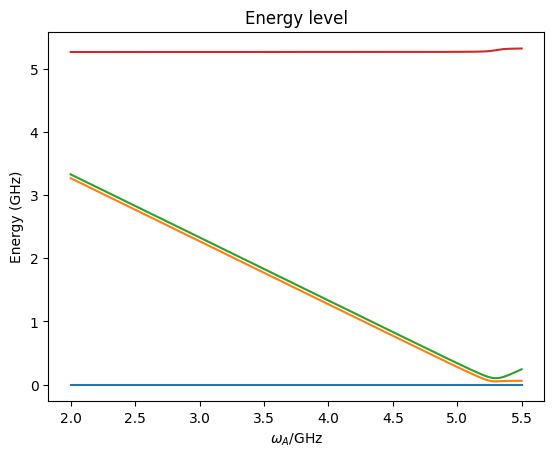

0

In [80]:
earr = np.transpose(np.array(energy_level_list))
elist_new = []
elist_new.append((earr[1] - earr[1]))
elist_new.append((earr[2] - earr[1]))
elist_new.append((earr[3] - earr[1]))
elist_new.append((earr[4] - earr[1]))
earr_new = np.transpose(elist_new)
%matplotlib inline
pl.plot_Elevel_dynamics(w3_scan_space, earr_new, [0,4], "\omega_A")

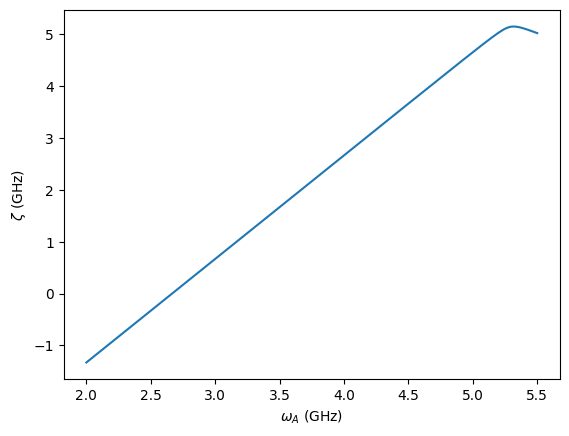

2.6656656656656654


In [81]:
ssarr = elist_new[3] - elist_new[2] - elist_new[1]
plt.plot(w3_scan_space, ssarr)
plt.ylabel(r'$\zeta$ (GHz)')
plt.xlabel(r'$\omega_A$ (GHz)')
plt.show()
index = np.argmin(np.abs(ssarr))
print(w3_scan_space[index])

### System dynamics


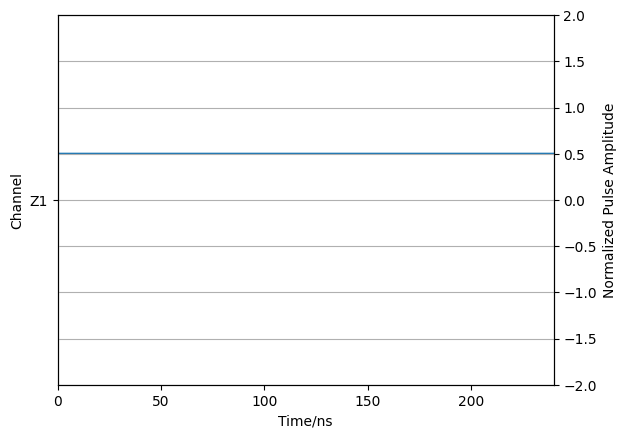

0

In [106]:
# state_000, E_000, _ = _system_arb.get_eigenstates_energy((0,0,0))
# state_010, E_010, _ = _system_arb.get_eigenstates_energy((0,1,0))
# state_100, E_100, _ = _system_arb.get_eigenstates_energy((1,0,0))
# state_110, E_110, _ = _system_arb.get_eigenstates_energy((1,1,0))

# state_101, E_101, _ = _system_arb.get_eigenstates_energy((1,0,1))
# state_011, E_011, _ = _system_arb.get_eigenstates_energy((0,1,1))

# L00 = (-state_010 + state_100)/np.sqrt(2)
# L10 = (state_010 + state_100)/np.sqrt(2)
# L01 = (-state_011 + state_101)/np.sqrt(2)
# L11 = (state_011 + state_101)/np.sqrt(2)

# E_L00 = (-E_010 + E_100)/np.sqrt(2)
# E_L10 = (E_010 + E_100)/np.sqrt(2)
# E_L01 = (-E_011 + E_101)/np.sqrt(2)
# E_L11 = (E_011 + E_101)/np.sqrt(2)


simulation_option = {
    "simulation_time": 240, # ns
    "simulation_step": 40000,
    "initial_state": [L00, L01, L10, L11] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 0,
        'type': "Z", # 'XY' or 'Z'
        'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau': simulation_option["simulation_time"] , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'epsilon': 0.1,
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.5,
        'q_index': 1 # 0, 1, 2
    }
    # {
    #     'pulse_index': 1,
    #     'type': "XY", # 'XY' or 'Z'
    #     'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
    #     't_delay': 10, # unit in ns
    #     't_width': 20, # unit in ns
    #     't_plateau': 0 , # unit in ns
    #     'freq': freq_list[2][1], # unit in GHz; Z pulse does not use it
    #     'pulse_detuning': 0,
    #     'phase': 0, # unit in rad;
    #     'amplitude': 0.05,
    #     'q_index': 2 # 0, 1, 2
    # }
    # ,
    # {
    #     'pulse_index': 1,
    #     'type': "Z", # 'XY' or 'Z'
    #     'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
    #     't_delay': simulation_option["simulation_time"] -42.9487,# 51.025, # unit in ns
    #     't_width': 42.9487,# 51.025, # unit in ns
    #     't_plateau': 0 , # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'epsilon': 0.5,
    #     'pulse_detuning': 0,
    #     'phase': 0, # unit in rad;
    #     'amplitude': 3.0916,#2.975,
    #     'q_index': 2 # 0, 1, 2
    # }
]

t_cz_w = 42.9487 #51.025
tspace = 50#60.6015
tdely = 0
thpi = 20

# pulse_sequence = [
#     {
#         'pulse_index': 0,
#         'type': "Z", # 'XY' or 'Z'
#         'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
#         't_delay': 0, # unit in ns
#         't_width': 0, # unit in ns
#         't_plateau': simulation_option["simulation_time"] , # unit in ns
#         'freq': 0, # unit in GHz; Z pulse does not use it
#         'epsilon': 0.1,
#         'pulse_detuning': 0,
#         'phase': 0, # unit in rad;
#         'amplitude': 0.5,
#         'q_index': 1 # 0, 1, 2
#     }
#     ,
#     {
#         'pulse_index': 1,
#         'type': "XY", # 'XY' or 'Z'
#         'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
#         't_delay': tdely, # unit in ns
#         't_width': thpi, # unit in ns
#         't_plateau': 0 , # unit in ns
#         'freq': freq_list[2][1], # unit in GHz; Z pulse does not use it
#         'pulse_detuning': 0,
#         'phase': np.pi/2, # unit in rad;
#         'amplitude': -0.02512,
#         'q_index': 2 # 0, 1, 2
#     }
#     ,
#     {
#         'pulse_index': 2,
#         'type': "Z", # 'XY' or 'Z'
#         'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
#         't_delay': tdely + thpi + tspace, # unit in ns
#         't_width': t_cz_w, # unit in ns
#         't_plateau': 0 , # unit in ns
#         'freq': 0, # unit in GHz; Z pulse does not use it
#         'epsilon': 0.1,
#         'pulse_detuning': 0,
#         'phase': 0, # unit in rad;
#         'amplitude': 3.0916, #2.975,
#         'q_index': 2 # 0, 1, 2
#     }
#     ,
#     {
#         'pulse_index': 3,
#         'type': "XY", # 'XY' or 'Z'
#         'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
#         't_delay': tdely + thpi + 2*tspace + t_cz_w, # unit in ns
#         't_width': thpi, # unit in ns
#         't_plateau': 0 , # unit in ns
#         'freq': freq_list[2][1], # unit in GHz; Z pulse does not use it
#         'pulse_detuning': 0,
#         'phase': np.pi/2, # unit in rad;
#         'amplitude': 0.02512,
#         'q_index': 2 # 0, 1, 2
#     }
# ]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(copy.deepcopy(pulse_sequence), simulation_option)

In [108]:
print(E_L11,
E_L10,
E_L01,
E_L00)
print(E_L11-E_L01-E_L10+E_L00)

13.04338267857196 8.558729486677056 0.3530947073066548 0.3530947073066372
4.484653191894887


In [72]:
pop = []
tp_list = np.linspace(5,7.5,20)
tw_list = np.linspace(6,9,20)
for tp in tp_list:
    dummy_list = []
    for tw in tw_list :
        ps = copy.deepcopy(pulse_sequence)
        ps[0]['t_width'] = tw
        ps[0]['t_plateau'] = tp
        result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, ps)
        result = result_list[0]
        dummy_list.append(aqs.expect(result.states, state_01 * aqs.dag(state_01))[-1])
    pop.append(dummy_list)

Exception: Operator and state do not have same tensor structure: [2, 2, 2] and [2, 2]

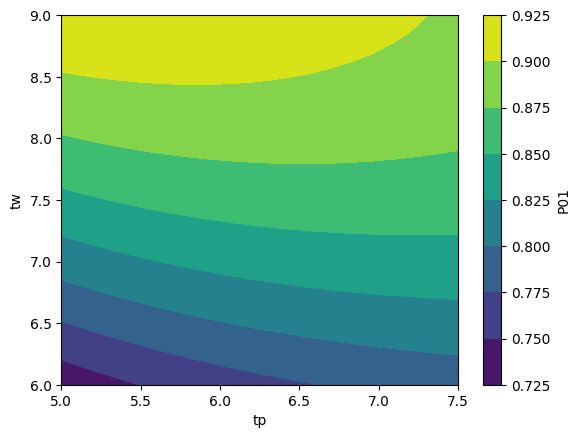

In [ ]:
tp_list, tw_list = np.meshgrid(tp_list, tw_list)

plt.figure()
plt.contourf(tp_list, tw_list, pop, cmap='viridis')
plt.colorbar(label='P01')
# Setting the labels
plt.xlabel('tp')
plt.ylabel('tw')
plt.show()

In [47]:
result_list, _ = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)

In [53]:
theta_00 = np.angle(L0.dag()*result_list[0].states[-1])[0][0]
theta_01 = np.angle(L01.dag()*result_list[1].states[-1])[0][0]
theta_10 = np.angle(L1.dag()*result_list[2].states[-1])[0][0]
theta_11 = np.angle(L11.dag()*result_list[3].states[-1])[0][0]

print(r"theta0L0 = "+f"{np.angle(L0.dag()*result_list[0].states[-1])[0][0]}")

print(r"theta0L1 = "+f"{np.angle(L01.dag()*result_list[1].states[-1])[0][0]}")

print(r"theta1L0 = "+f"{np.angle(L1.dag()*result_list[2].states[-1])[0][0]}")

print(r"theta1L1 = "+f"{np.angle(L11.dag()*result_list[3].states[-1])[0][0]}")
theta_11 - theta_01 - theta_10 - theta_00

theta0L0 = 0.10098846902274924
theta0L1 = -0.08660165525324805
theta1L0 = 1.5483278676192433
theta1L1 = -1.5339189768409645


-3.096633658229709

In [17]:
EL1 = (E_100 + E_010)/np.sqrt(2)
EL0 = (-E_100 + E_010)/np.sqrt(2)
EL11 = (E_101 + E_011)/np.sqrt(2)
EL01 = (-E_101 + E_011)/np.sqrt(2)
EL1-EL0

8.855064679956664

In [325]:
EL11-EL01-EL1+EL0

4.4846531918949095

In [270]:
ang.cal_angle(result_list, simulation_option)

-4.5943208389943155

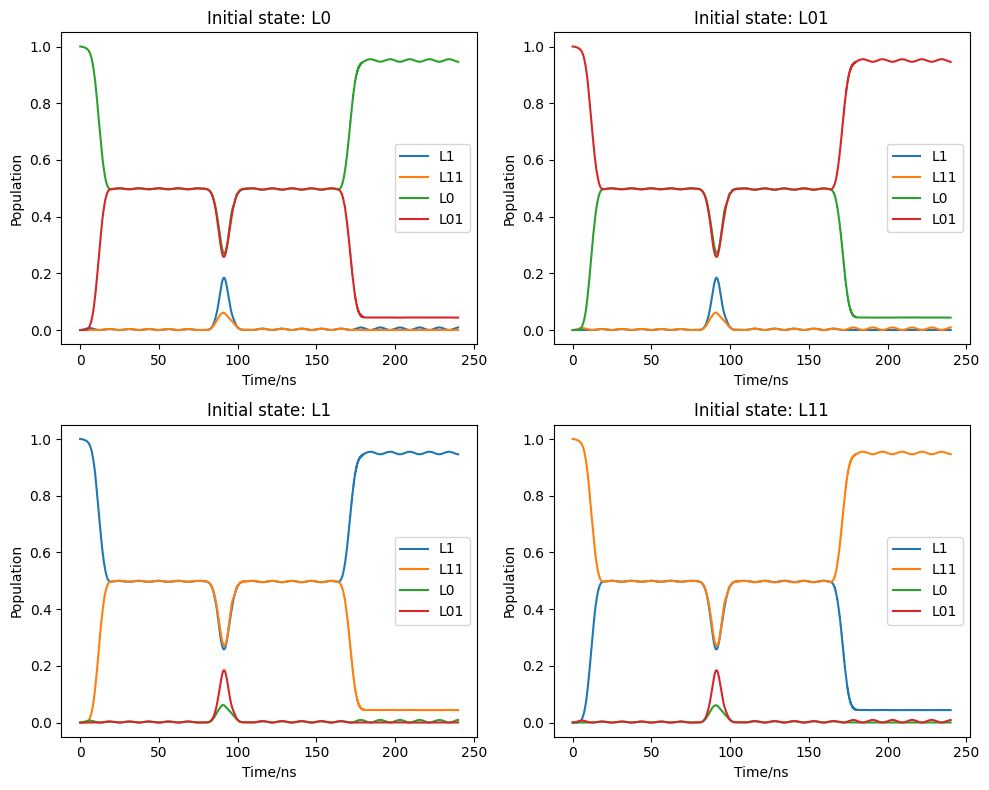

0

In [301]:
# state that you want to plot each simulation
interested_state = [
                    [L1, L11, L0, L01],
                    [L1, L11, L0, L01],
                    [L1, L11, L0, L01],
                    [L1, L11, L0, L01]
                    ]
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system_arb, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

### scan Half-pi pulse

In [180]:
twidth_rng = np.linspace(10, 20, 40)
amp_rng = np.linspace(0.02, 0.07, 40)
pulse_sequence1 = copy.deepcopy(pulse_sequence)
pop2D = []
for twid in twidth_rng:
    dummy_list = []
    for amp in amp_rng:
        pulse_sequence1[1]["t_width"] = twid
        pulse_sequence1[1]["amplitude"] = amp
        pulse_sequence1[1]["t_delay"] = simulation_option["simulation_time"] - twid
        result_list, _ = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence1)
        result = result_list[0]
        state = ket2dm(result.states[-1]).ptrace(2)
        dummy_list.append(aqs.expect(state_list, basis(2, 0) * aqs.dag(basis(2, 0))))
    pop2D.append(dummy_list)

In [184]:
indices = []
toler = 0.0005
for i in range(len(twidth_rng)):
    for j in range(len(amp_rng)):
        if  0.5 -toler< pop2D[i][j] < 0.5 +toler:
            indices.append([i,j])
indices

[[39, 4]]

In [185]:
print(twidth_rng[39], amp_rng[4])

20.0 0.025128205128205128


In [182]:
import pickle

data = {
    "tw_rng": twidth_rng,
    "amp_rng": amp_rng,
    "angle": pop2D
}

pickle.dump(data, open("Xpi2_calib.pkl", "wb"))

### Scan the CZ gate

In [279]:
twidth_rng = np.linspace(25, 60, 40)
amp_rng = np.linspace(2.8, 3.125, 40)
pulse_sequence1 = copy.deepcopy(pulse_sequence)
angle2D = []
for twid in twidth_rng:
    dummy_list = []
    for amp in amp_rng:
        pulse_sequence1[1]["t_width"] = twid
        pulse_sequence1[1]["amplitude"] = amp
        pulse_sequence1[1]["t_delay"] = simulation_option["simulation_time"] - twid
        result_list, _ = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence1)
        dummy_list.append(ang.cal_angle(result_list, simulation_option))
    angle2D.append(dummy_list)

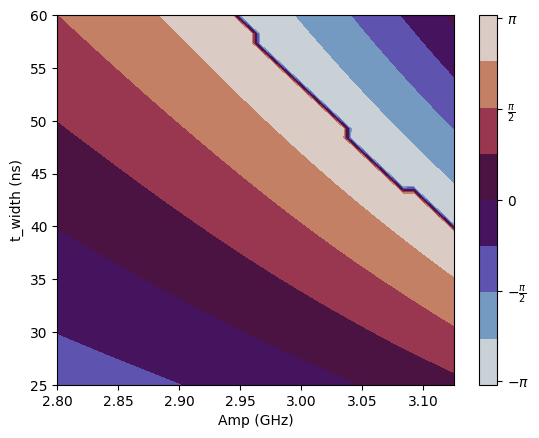

In [280]:
amp_ls, twidth_ls = np.meshgrid(amp_rng, twidth_rng)

from matplotlib.colors import TwoSlopeNorm

normalized_angle2D = (np.array(angle2D) + np.pi) % (2 * np.pi) - np.pi
# Define the range for the color map normalization around 0
norm = TwoSlopeNorm(vmin=-np.pi, vcenter=0, vmax=np.pi)

# Create the figure and the contour plot
plt.figure()
contour = plt.contourf(amp_ls, twidth_ls, normalized_angle2D, cmap='twilight', norm=norm)

# Create the colorbar with custom ticks
cbar = plt.colorbar(contour, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.ax.set_yticklabels(['$-\pi$', '$-\\frac{\pi}{2}$', '0', '$\\frac{\pi}{2}$', '$\pi$'])

# Set the labels
plt.xlabel('Amp (GHz)')
plt.ylabel('t_width (ns)')
plt.show()


# plt.figure()
# plt.contourf(amp_ls, twidth_ls, angle2D, cmap='viridis')
# plt.colorbar(label=r'$\phi$ (rad)')
# # Setting the labels
# plt.xlabel('Amp (GHz)')
# plt.ylabel('t_width (ns)')
# plt.show()

In [281]:
import pickle

data = {
    "tw_rng": twidth_rng,
    "amp_rng": amp_rng,
    "angle": angle2D
}

pickle.dump(data, open("CZ_angle_calib.pkl", "wb"))

In [283]:
indices = []
tolar = 0.003
for i in range(len(twidth_rng)):
    for j in range(len(amp_rng)):
        if  np.pi -tolar< normalized_angle2D[i][j] < np.pi +tolar:
            indices.append([i,j])
indices

[[20, 35]]

In [284]:
a,b = indices[0][0], indices[0][1]
print(angle2D[a][b], twidth_rng[a], amp_rng[b])

# Fid = angle2D[20]
# indices = [i for i, fid in enumerate(Fid) if  np.pi -0.01< fid < np.pi +0.01]
# indices

3.140489723968322 42.94871794871795 3.091666666666667


### Scan spacing tspace

In [286]:
pop1D = []
tspace_rng = np.linspace(0,60,400)
for tsp in tqdm(tspace_rng):
    t_cz_w = 42.9487 #51.025
    tspace = tsp#60.6015
    tdely = 0
    thpi = 20

    pulse_sequence = [
        {
            'pulse_index': 0,
            'type': "Z", # 'XY' or 'Z'
            'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
            't_delay': 0, # unit in ns
            't_width': 0, # unit in ns
            't_plateau': simulation_option["simulation_time"] , # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'epsilon': 0.1,
            'pulse_detuning': 0,
            'phase': 0, # unit in rad;
            'amplitude': 0.5,
            'q_index': 1 # 0, 1, 2
        }
        ,
        {
            'pulse_index': 1,
            'type': "XY", # 'XY' or 'Z'
            'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
            't_delay': tdely, # unit in ns
            't_width': thpi, # unit in ns
            't_plateau': 0 , # unit in ns
            'freq': freq_list[2][1], # unit in GHz; Z pulse does not use it
            'pulse_detuning': 0,
            'phase': np.pi/2, # unit in rad;
            'amplitude': -0.02512,
            'q_index': 2 # 0, 1, 2
        }
        ,
        {
            'pulse_index': 2,
            'type': "Z", # 'XY' or 'Z'
            'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
            't_delay': tdely + thpi + tspace, # unit in ns
            't_width': t_cz_w, # unit in ns
            't_plateau': 0 , # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'epsilon': 0.1,
            'pulse_detuning': 0,
            'phase': 0, # unit in rad;
            'amplitude': 3.0916, #2.975,
            'q_index': 2 # 0, 1, 2
        }
        ,
        {
            'pulse_index': 3,
            'type': "XY", # 'XY' or 'Z'
            'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
            't_delay': tdely + thpi + 2*tspace + t_cz_w, # unit in ns
            't_width': thpi, # unit in ns
            't_plateau': 0 , # unit in ns
            'freq': freq_list[2][1], # unit in GHz; Z pulse does not use it
            'pulse_detuning': 0,
            'phase': np.pi/2 - 0.1*np.pi, # unit in rad;
            'amplitude': 0.02512,
            'q_index': 2 # 0, 1, 2
        }
    ]
    result_list, _ = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)
    dummy= []
    for res in result_list:
        state = ket2dm(result.states[-1]).ptrace(2)
        dummy.append(aqs.expect(state, basis(2, 0) * aqs.dag(basis(2, 0))))
    pop1D.append(dummy)

pop1D = np.transpose(np.array(pop1D))    

data = {
    "tspace_rng": tspace_rng,
    "pop1D": pop1D
}

pickle.dump(data, open("CX_calib.pkl", "wb"))

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [1:36:48<00:00, 14.52s/it]


In [292]:
indices = []
toler = 0.00084
for i in range(len(tspace_rng)):
    if 0-toler<pop1D[i] <0+toler:
        indices.append([i])
indices

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
print(tspace_rng[274], pop1D[274])

60.6015037593985 0.0008399658068959338


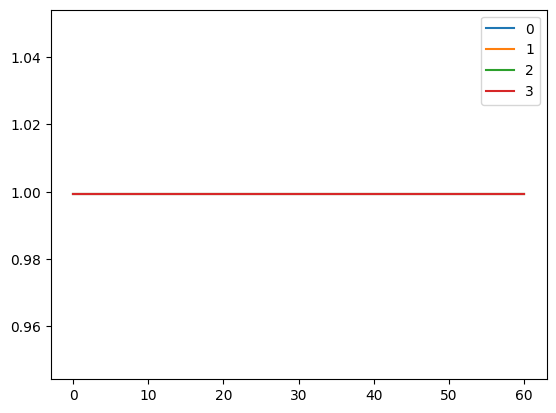

In [ ]:
plt.figure()
for ii, case in enumerate(pop1D):
    plt.plot(tspace_rng,case, label=f"{ii}")
plt.legend()
plt.show()

### Density matrix plot
#### Ancilla plot

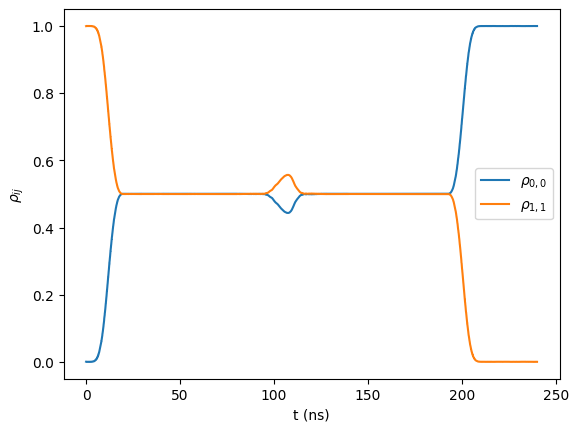

0.9991861588436306
0.0008138411563692606


In [247]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[2]

state_list = [ket2dm(st).ptrace(2) for st in result.states]
# Plot
%matplotlib inline

plt.plot(t,aqs.expect(state_list, basis(2, 0) * aqs.dag(basis(2, 0))), label=r'$\rho_{0,0}$');

plt.plot(t,aqs.expect(state_list, basis(2, 1) * aqs.dag(basis(2, 1))), label=r'$\rho_{1,1}$');

plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

print(aqs.expect(state_list, basis(2, 0) * aqs.dag(basis(2, 0)))[-1])
print(aqs.expect(state_list, basis(2, 1) * aqs.dag(basis(2, 1)))[-1])

#### Logic bit plot

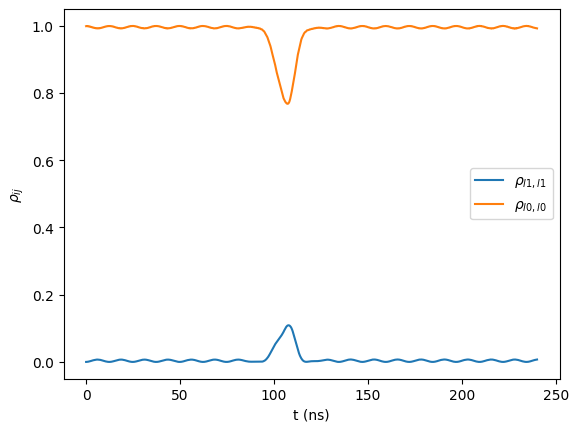

In [243]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]
state_list = [ket2dm(st).ptrace([0,1]) for st in result.states]

# Plot
%matplotlib inline

plt.plot(t,aqs.expect(state_list, l1 * aqs.dag(l1)), label=r'$\rho_{l1,l1}$');

plt.plot(t,aqs.expect(state_list, l0 * aqs.dag(l0)), label=r'$\rho_{l0,l0}$');

plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

## Scan CZ gate

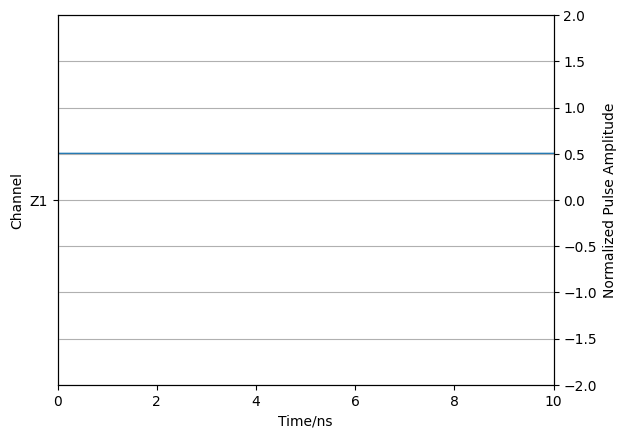

0

In [65]:
freq_list = [
    [0, 6.3],
    [0, 6.3],
    [0, 5]
]

inter_list = [
    {
        "v01": 1
    },
    {
        "v01": 1
    },
    {
        "v01": 1
    }
]

r_dic = {
    "r12": 0.04,
    "r23": 0.12
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list = [
    {
        "v01": 0
    },
    {
        "v01": 0
    }
    ,
    {
        "v01": 0
    }
]

driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }

]

bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }

]

gamma_list = [
    {
        'up': 0,
        'down': 0,
        'z': 0
    },
    {
        'up': 0,
        'down': 0,
        'z': 0
    },
    {
        'up': 0,
        'down': 0,
        'z': 0
    }
]


# gamma_list = None

_system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)
_system_arb.H

state_000, E_000, _ = _system_arb.get_eigenstates_energy((0,0,0))
state_010, E_010, _ = _system_arb.get_eigenstates_energy((0,1,0))
state_100, E_100, _ = _system_arb.get_eigenstates_energy((1,0,0))
state_110, E_110, _ = _system_arb.get_eigenstates_energy((1,1,0))
state_101, E_101, _ = _system_arb.get_eigenstates_energy((1,0,1))
state_011, E_011, _ = _system_arb.get_eigenstates_energy((0,1,1))

L1 = (state_100 + state_010)/np.sqrt(2)
L0 = (-state_100 + state_010)/np.sqrt(2)
L11 = (state_101 + state_011)/np.sqrt(2)
L01 = (-state_101 + state_011)/np.sqrt(2)

simulation_option = {
    "simulation_time": 10, # ns
    "simulation_step": 30000,
    "initial_state": [L0, L1, L01, L11] # Do multiple simulation
}

tspace = 15
tdely = 30
thpi = 10
tswap = 40

pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "Z", # 'XY' or 'Z'
        'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau': 130 , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'epsilon': 0.1,
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.5,
        'q_index': 1 # 0, 1, 2
    }
    # ,
    # {
    #     'pulse_index': 1,
    #     'type': "XY", # 'XY' or 'Z'
    #     'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
    #     't_delay': tdely, # unit in ns
    #     't_width': thpi, # unit in ns
    #     't_plateau': 0 , # unit in ns
    #     'freq': 5, # unit in GHz; Z pulse does not use it
    #     'pulse_detuning': 0,
    #     'phase': 0, # unit in rad;
    #     'amplitude': 0.05,
    #     'q_index': 2 # 0, 1, 2
    # }
    # ,
    # {
    #     'pulse_index': 2,
    #     'type': "Z", # 'XY' or 'Z'
    #     'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
    #     't_delay': tdely + thpi + tspace, # unit in ns
    #     't_width': 2, # unit in ns
    #     't_plateau': tswap , # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'epsilon': 0.1,
    #     'pulse_detuning': 0,
    #     'phase': 0, # unit in rad;
    #     'amplitude': 1.3,
    #     'q_index': 2 # 0, 1, 2
    # }
    # ,
    # {
    #     'pulse_index': 3,
    #     'type': "XY", # 'XY' or 'Z'
    #     'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
    #     't_delay': tdely + thpi + 2*tspace + tswap, # unit in ns
    #     't_width': thpi, # unit in ns
    #     't_plateau': 0 , # unit in ns
    #     'freq': 5, # unit in GHz; Z pulse does not use it
    #     'pulse_detuning': 0,
    #     'phase': np.pi/2, # unit in rad;
    #     'amplitude': 0.05,
    #     'q_index': 2 # 0, 1, 2
    # }
    # ,
    # ,
    # {
    #     'pulse_index': 1,
    #     'type': "Z", # 'XY' or 'Z'
    #     'pulse_shape': "cosh", # See PulseGen/pulse_shape.py
    #     't_delay': 70, # unit in ns
    #     't_width': 2, # unit in ns
    #     't_plateau': 8 , # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'epsilon': 0.1,
    #     'pulse_detuning': 0,
    #     'phase': 0, # unit in rad;
    #     'amplitude': 1.3,
    #     'q_index': 2 # 0, 1, 2
    # }
    # ,
    # {
    #     'pulse_index': 2,
    #     'type': "XY", # 'XY' or 'Z'
    #     'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
    #     't_delay': 60 + 13, # unit in ns
    #     't_width': 10, # unit in ns
    #     't_plateau': 0 , # unit in ns
    #     'freq': 4, # unit in GHz; Z pulse does not use it
    #     'pulse_detuning': 0,
    #     'phase': np.pi, # unit in rad;
    #     'amplitude': 0.05,
    #     'q_index': 2 # 0, 1, 2
    # }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(copy.deepcopy(pulse_sequence), simulation_option)

In [89]:
E_110 + E_000 - E_100 - E_010

-7.105427357601002e-15

In [66]:
propagator = _system_arb.system_dynamics_propagator(simulation_option, pulse_sequence)

12.5%. Run time:   2.66s. Est. time left: 00:00:00:18
25.0%. Run time:   2.91s. Est. time left: 00:00:00:08
37.5%. Run time:   3.16s. Est. time left: 00:00:00:05
50.0%. Run time:   3.44s. Est. time left: 00:00:00:03
62.5%. Run time:   3.56s. Est. time left: 00:00:00:02
75.0%. Run time:   3.89s. Est. time left: 00:00:00:01
87.5%. Run time:   4.26s. Est. time left: 00:00:00:00
100.0%. Run time:   4.38s. Est. time left: 00:00:00:00
Total run time:   4.42s


In [151]:
Fid = []
for prop in propagator:
    Fid.append(np.angle(L11.dag() * prop * L11)[0][0] + np.angle(L01.dag() * prop * L01)[0][0] - np.angle(L1.dag() * prop * L1)[0][0] - np.angle(L0.dag() * prop * L0)[0][0] )
indices = [i for i, fid in enumerate(Fid) if  np.pi -0.001< fid < np.pi +0.001]

In [163]:
t[28087]

9.36264542151405

In [150]:
np.angle(L01.dag() * propagator[20595] * L01)

array([[-0.25249388]])

In [162]:
prop = propagator[23581]
np.angle(L11.dag() * prop * L11)[0][0] + np.angle(L01.dag() * prop * L01)[0][0] - np.angle(L1.dag() * prop * L1)[0][0] - np.angle(L0.dag() * prop * L0)[0][0]

3.1415108770039213

In [152]:
indices

[10664, 22079, 23581, 26585, 28087]

In [126]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])
%matplotlib qt
plt.figure()
plt.plot(t, Fid )
plt.xlabel('time (ns)')
plt.ylabel('F')
plt.show()

In [46]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)

In [50]:
angle_list = []
for i, res in enumerate(result_list):
    angle_list.append(phase_tracking(res, simulation_option["initial_state"][i]))

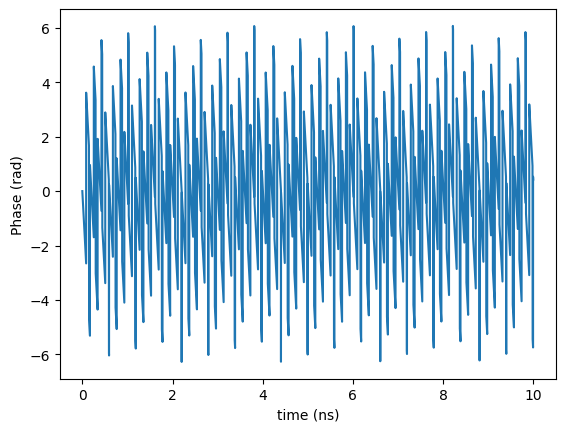

In [64]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])
%matplotlib inline
plt.figure()
plt.plot(t, np.array(angle_list[2] - np.array(angle_list[0]) ))
plt.xlabel('time (ns)')
plt.ylabel('Phase (rad)')
plt.show()